# Module 4 Lab 1 - DICOM Image file format
In this lab, we will learn to access data stored in DICOM image format files.  We will manipulate both the image data itself, and the metadata stored with the image.  We are going to look at images in DICOM format that were collected from: https://wiki.cancerimagingarchive.net/display/Public/Brain-Tumor-Progression

We will be examining one patient's MRI scans in this lab.  This patient had two scans several months apart, with intervening therapy.  The file structure looks like:

```
Brain-Tumor-Progression
  |_ PGBM-001 (the patient identifier in the study)
    |_ 11-19-1991-FH-HEADBrain Protocols-40993 (folder for the scan date)
        |_ 11.000000-T1post-03326 (folder for the scan series)
            |_ 1-01.dcm (sequential scan file)
            ...
            |_ 1-25.dcm (sequential scan file)
    |_ 04-02-1992-FH-HEADBrain Protocols-79896 (folder for the scan date)
        |_ 11.000000-T1post-80644 (folder for the scan series)
            |_ 1-01.dcm (sequential scan file)
            ...
            |_ 1-24.dcm (sequential scan file)
      
```

There are two study dates for this patient.  In each study, there are multiple series.  For this lab we have only one of the series for these studies (the T1post).  Under each series are the dicom images.  25 for the first study series and 24 for the second study series.

In [1]:
import sys
!{sys.executable} -m pip install pydicom scikit-image
import pydicom
import skimage
import numpy as np
import pandas as pd



     |████████████████████████████████| 2.0MB 3.6MB/s eta 0:00:01


## Reading the image metadata
First we will read the file. DICOM format stores more than just the image data.  Lets see what else it has for us besides the image.  We can simply use the print() function to see all of the metadata. 

In [2]:
# we will load two images from the series

root_image_dir = '../resources/Brain-Tumor-Progression/PGBM-001/11-19-1991-FH-HEADBrain Protocols-40993/11.000000-T1post-03326/'
img01 = pydicom.dcmread(f'{root_image_dir}1-01.dcm') # first image in the series
img25 = pydicom.dcmread(f'{root_image_dir}1-25.dcm') # last image in the series

print(img01)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 196
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.4429.7055.185825175271464138518729711479
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.35'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'M', 'NORM', 'DIS2D']
(0008, 0012) Instance Creation Date              DA: '19911119'
(0008, 0013) Instance Creation Time              TM: '082843.046000'
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0

There are a lot of results.  The results give us a tag identifier in the parentheses, along with a description, the data type ("value representation"), and the value.

The value representations are available here: http://dicom.nema.org/dicom/2013/output/chtml/part05/sect_6.2.html

Tags are made up of a Group Number and an Element Number, which are hexadecimal numbers.  For example, group 0010 is for patient data.

Tags are standardized and can be looked up online: 
* The official specification, includes the tags and keywords: http://dicom.nema.org/Dicom/2011/11_06pu.pdf
* An online source for searching by tag: https://www.dicomlibrary.com/dicom/dicom-tags/

Interpreting all of these values is beyond the scope of this lab, but you can see that there is a lot more information in here than just the image of the scan.  For example, you can see the `Study Date`, `Study Time`, `Accession Number`, and `Modality` of the image (tags (0008, 0020), (0008, 0030), (0008, 0050), and (0008, 0060), respectively).  

You can also find information about the image format:
```
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows                                US: 320
(0028, 0011) Columns                             US: 260
(0028, 0030) Pixel Spacing                       DS: ['0.687500', '0.687500']
(0028, 0100) Bits Allocated                      US: 16
(0028, 0101) Bits Stored                         US: 16
(0028, 0102) High Bit                            US: 15
(0028, 0103) Pixel Representation                US: 1
(0028, 0303) Longitudinal Temporal Information M CS: 'MODIFIED'
(0028, 1050) Window Center                       DS: "931"
(0028, 1051) Window Width                        DS: "1738"
(0028, 1055) Window Center & Width Explanation   LO: 'LINEAR'
```
So we know to expect a monochrome image of 320x260, with 16 bits of resolution.  

## Getting the image data

Pydicom makes the actual image data available in a property of the image object: `pixel_array`.  When accessing the `pixel_array` property, pydicom will automatically uncompress the image if it is compressed, _and_ you have installed one of the decompression libraries it can use.  In this environment, it will use the PIL library.  See [the documentation](https://pydicom.github.io/pydicom/stable/old/working_with_pixel_data.html?highlight=image%20data%20handlers#dataset-pixel-array) for more information.

What we will get from the method call is a numpy array.

In [3]:
img01.pixel_array.shape

(320, 260)

This tells us that the image is 320 by 260 pixels in size.  It is a grayscale object, so it will be straighforward to work with, as each pixel has only one value: the pixel intensity. Had this image been in color, then each pixel would be described by three values: Red, Green, and Blue.  The shape of a color image would be (320, 260, 3), meaning a three dimensional object that for each x, y coordinate, contains an array of three values (RGB).

Now we will display the images using matplotlib's `imshow`.  The `pixel_array` attribute contains a numpy array of the raw, uncompressed data.  

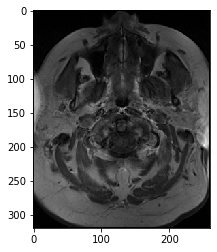

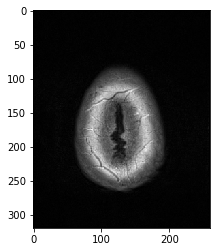

In [4]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

imshow(img01.pixel_array, cmap='gray')
plt.show()
imshow(img25.pixel_array, cmap='gray')
plt.show()


## Getting a dicom attribute
We can access any attribute from the dicom file using the attribute accessor, `[tag].value`, where tag is the hex encoded attribute consisting of the Group Number and Element Number.  

The dicom attribute `(0020, 1041) Slice Location` can be used to indicate the relative position of each slice.  Below, we will loop over all the images and display them along with the Slice Location.

For `(0020, 1041) Slice Location` we specify `0x00201041` as the tag, which is the Group Number (0020) and Element Number (1041) appended together.

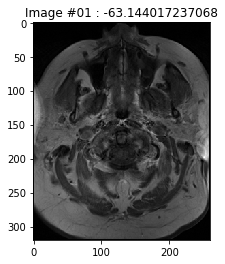

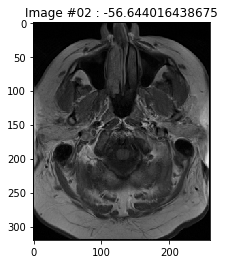

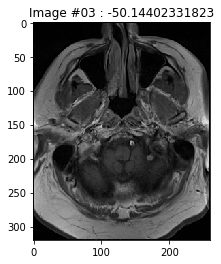

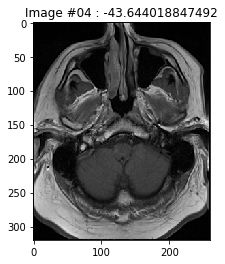

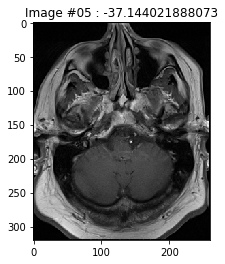

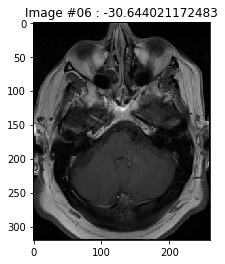

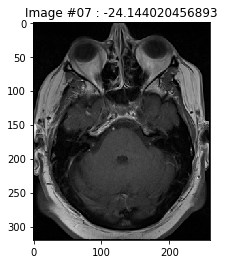

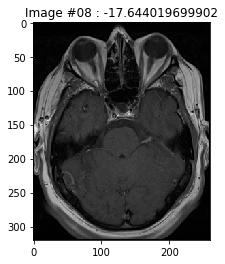

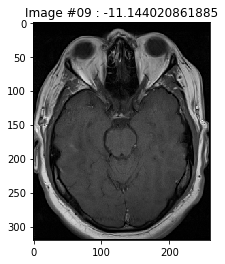

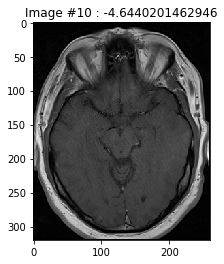

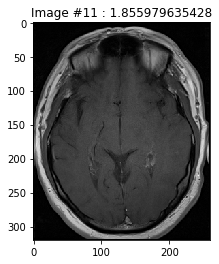

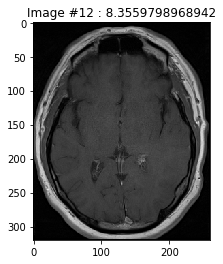

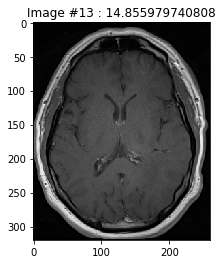

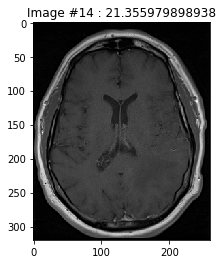

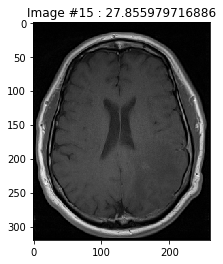

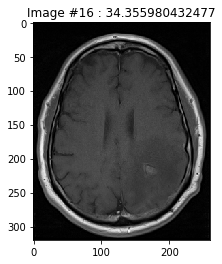

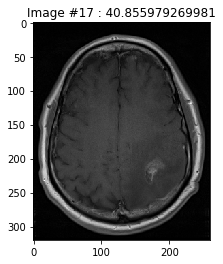

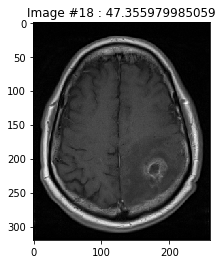

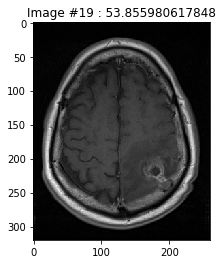

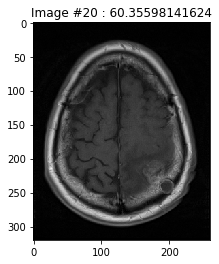

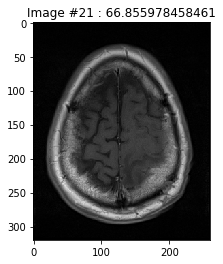

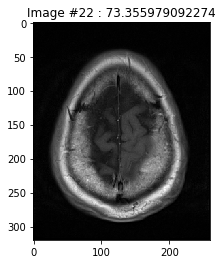

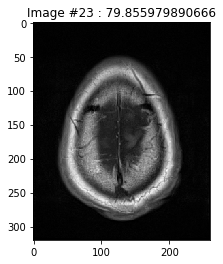

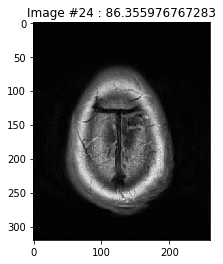

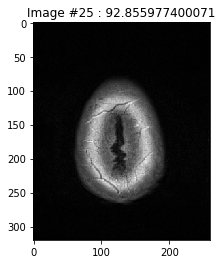

In [5]:
## loop over all the images, load them and store in an array
imgs = []
for i in range(1,26):
    filename = f'{root_image_dir}1-{i:02d}.dcm' # construct the filename we expect to be in our image directory
    imgs.append(pydicom.dcmread(filename))
    
# print each image with the slice location in the title
for i, img in enumerate(imgs):
    imshow(img.pixel_array, cmap='gray')
    plt.title(f'Image #{i+1:02d} : {img[0x00201041].value}')
    plt.show()

The tumor starts becoming visible in image 15, in the lower left quadrant of the image.

## Compare images
We can compare a slice from the prior slice, this could help to highlight abnormal structures.  We will reduce the grayscale depth to reduce noise in the diffs.

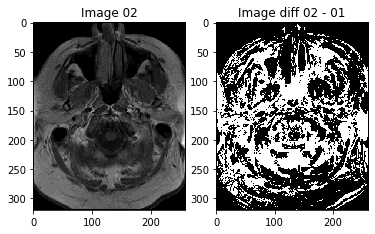

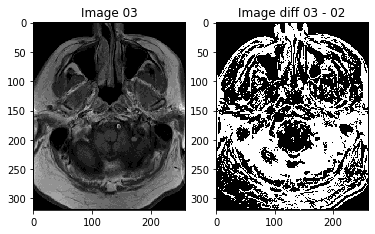

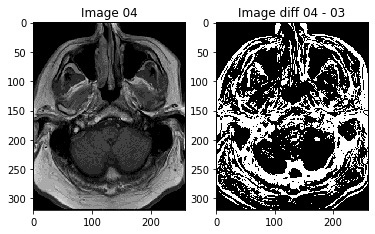

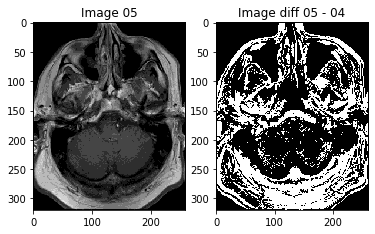

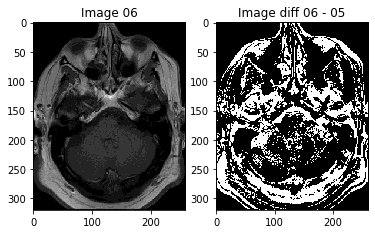

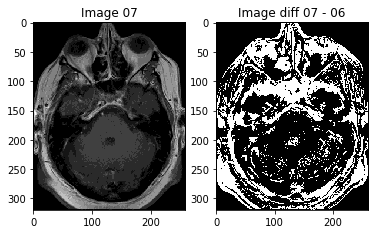

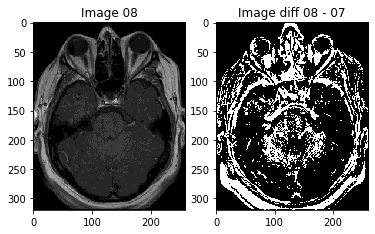

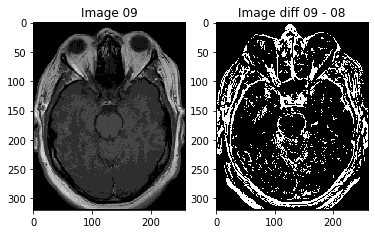

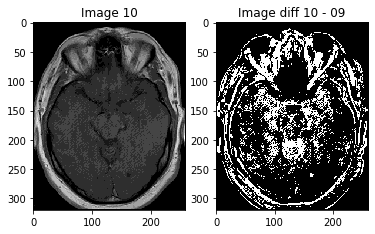

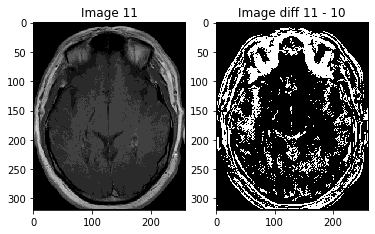

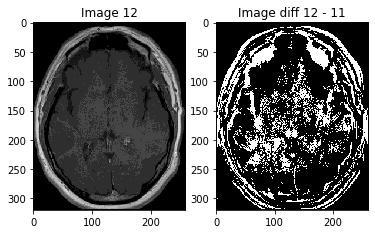

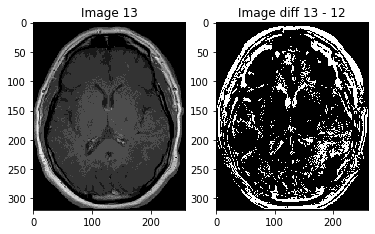

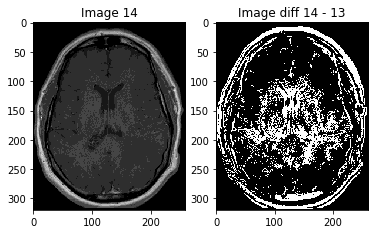

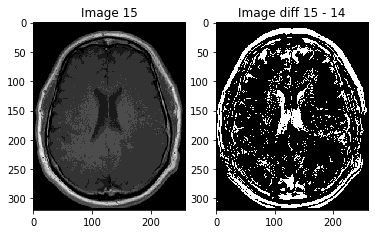

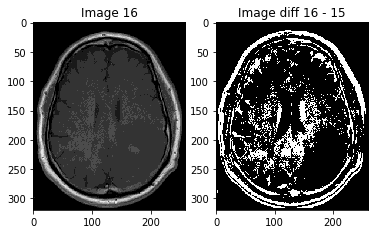

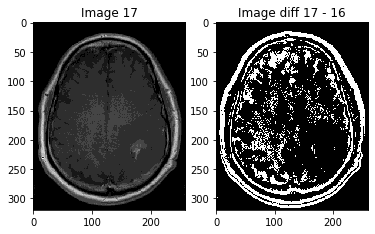

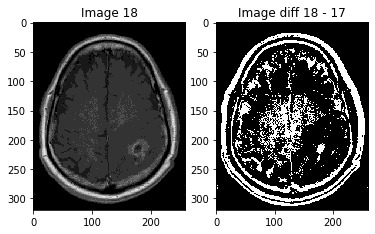

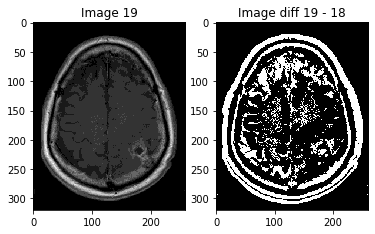

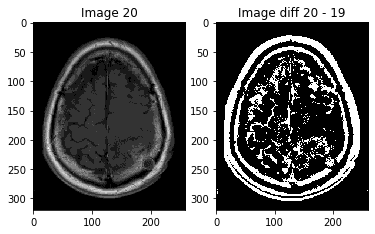

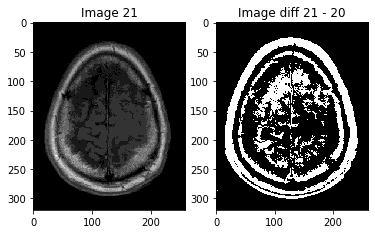

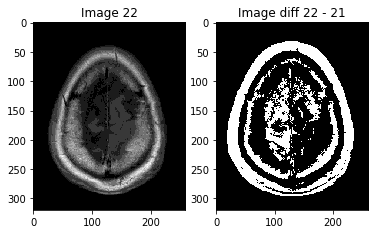

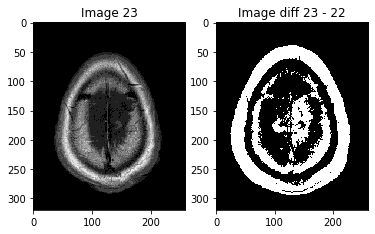

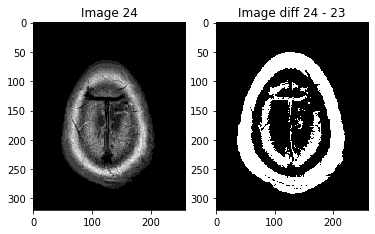

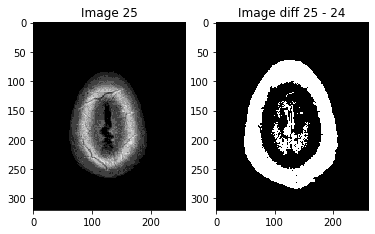

In [6]:
def reduce_colordepth(img, factor):
    return (img / factor).astype('uint16')

factor = 128

for i in range(0, len(imgs)-1):
    f, axes = plt.subplots(1,2)
    
    axes[0].imshow(reduce_colordepth(imgs[i+1].pixel_array, factor), cmap='gray')
    axes[0].set_title(f'Image {i+2:02d}')
    
    axes[1].imshow(reduce_colordepth(imgs[i+1].pixel_array, factor) - reduce_colordepth(imgs[i].pixel_array, factor), cmap='gray')
    axes[1].set_title(f'Image diff {i+2:02d} - {i+1:02d}')

    plt.show()

## Methods for automatic medical image annotation
We've looked at some DICOM images containing braim tumors, and have applied some simple transformations to the image data to analyze the scans; however, research in this space is discovereing many more advanced methods for automated detection, annotation, and segmentation of medical imaging.  These methods are usually very specific in their purpose and scope, and it's impossible to cover all of the published methods in this course. However, for an example specific to brain tumors, read the linked paper [Automated brain tumour detection and segmentation using superpixel-based extremely randomized trees in FLAIR MRI](../resources/Soltaninejad2017_Article_AutomatedBrainTumourDetectionA.pdf).  This method uses an ensemble method that generates additional features from the data and then applies extremely randomized trees (ERT) for the final classification.  Other methods that have shown success are leveraging Convolutional Neural Networks, which you can hear about more in this [video](https://www.youtube.com/watch?v=VKnoyiNxflk) from JAMA, and which we will explore in this module.



## DICOM metadata extraction
Given a collection of DICOM images, you can extract additional features from the image metadata.  For example, it's possible to capture the date/time of each set of images, and use the time between series as a feature in a machine learning algorithm.  

To extract features from DICOM, you need to know the tags that you want.  

Below we will retrieve all patient data (by group 0x0010) in the DICOM file, by using the `group_dataset` method.  We will also extract the patient name using both the tag and the keyword using two different methods.  See the `pydicom` [documentation](https://pydicom.github.io/pydicom/stable/) for more methods.

In [7]:
for data_element in imgs[0].group_dataset(0x0010):
    print(data_element.tag, data_element.VR, data_element.value, str(data_element))
    
# get patient name directly.  the index is the group 0010 and the element 0010 combined, represented as a hex value
print()
print(imgs[0][0x00100010].value)

# it can also be retrieved by keyword (see the nema documentation above for keywords)
print()
print(imgs[0].data_element('PatientName').value)

(0010, 0010) PN PGBM-001 (0010, 0010) Patient's Name                      PN: 'PGBM-001'
(0010, 0020) LO PGBM-001 (0010, 0020) Patient ID                          LO: 'PGBM-001'
(0010, 0030) DA  (0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) CS M (0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) AS 051Y (0010, 1010) Patient's Age                       AS: '051Y'
(0010, 1030) DS 174.6330846645 (0010, 1030) Patient's Weight                    DS: '174.6330846645'

PGBM-001

PGBM-001
